# Blak Hole binary formation channelwith gaussian mixtures

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset. 

Anyway. LIGO measures the masses of many black holes. You can find the dataset at `solutions/formationchannels.npy`.


*Hint*: Note that the data provided are of shape (N,1), not (N,). This might be confusing at first, but it's the format that sklearn wants (more on this in a future lecture).  A useful tool to convert between the two is [np.newaxis](https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it).

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from astroML import stats as astroMLstats



Dataset composed by the BH masses, in the right format for sklearn GMM

In [2]:
data = np.load('/Users/federicoastori/Desktop/ilovegit/WORK_6/formationchannels.npy') # masses of BHs measured by LIGO to train

Making an istogram and plotting some gaussians with $\mu$ and $\sigma$ took by hand, we can notice 3 channels

Text(0.5, 0, 'BH masses [$M_\\odot$]')

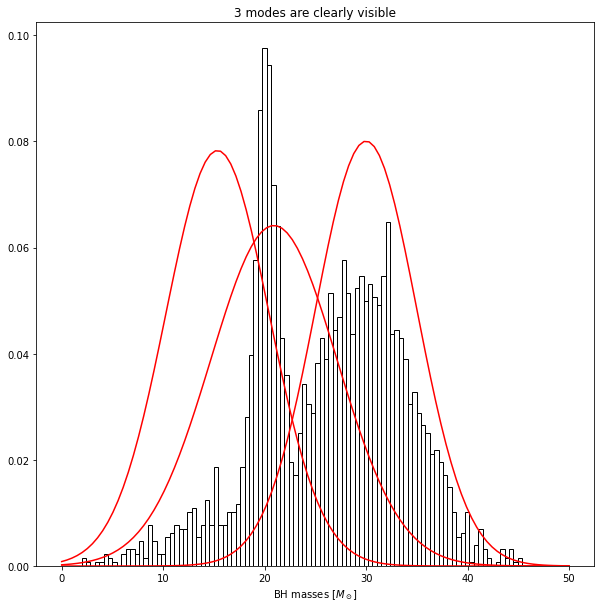

In [3]:
plt.figure(figsize=[10,10])
xg=np.linspace(0,50,100)
#data = data[np.newaxis,:]
plt.title('3 modes are clearly visible') # the 10% of the total mass are in binary, alone BH instead have the 6% (more or less)
plt.hist(data, bins=100, fill=False, density=True, label='dataset')
plt.plot(xg,norm.pdf(xg,loc=norm.fit(data[:200,0])[0],scale=norm.fit(data[:200,0])[1]), color='red') # loc=np.mean(data[:200]), scale=np.std(data[:200])
plt.plot(xg,norm.pdf(xg,loc=np.median(data[201:1470]), scale=astroMLstats.sigmaG(data[201:1470])), color='red')
plt.plot(xg,norm.pdf(xg,loc=np.mean(data[1471:]),scale=np.std(data[1475:])), color='red', label='by-eye-fit')
plt.xlabel('BH masses [$M_\odot$]')

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

- n_init = number of initialization to perform
- n_components = number of gaussians 

Attributes:

- .fit = prepare data to be trained (Estimate model parameters with the EM algorithm.)
- .aic = compute the Aikike information criterion (bias correction)
- .bic = bayesian approach of AIC

In order to understand the right number of components to pass at the GMM (# of gaussians) I use the AIC. I cannot use $\chi^2$ since the numbr of parameters change. The model with less AIC is the winner.

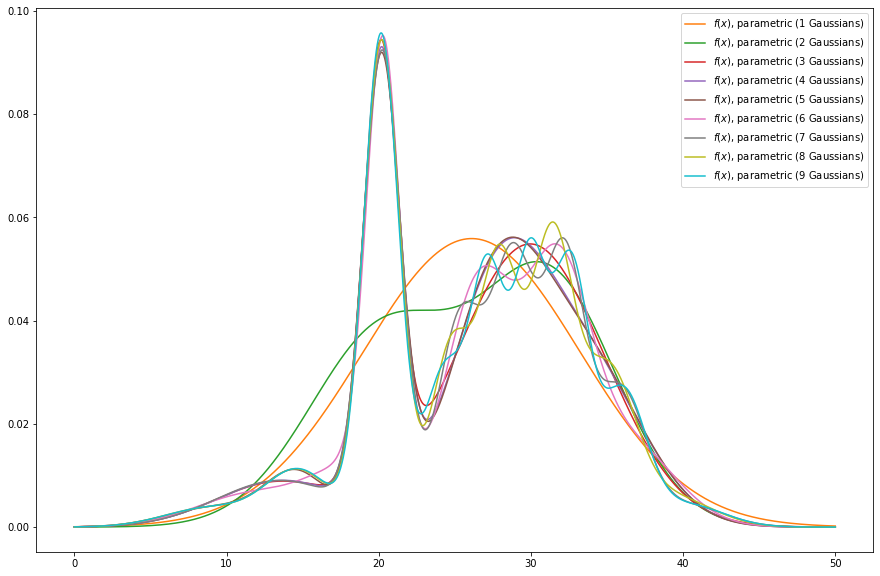

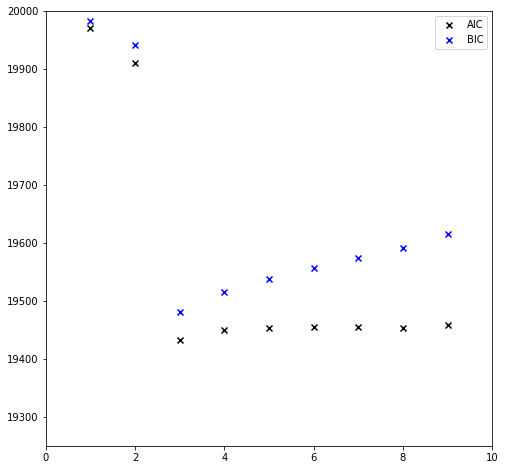

In [4]:
xgrid=np.linspace(0,50, 2950)
AIC=[]
BIC=[]

plt.figure(figsize=[15,10])
for i in range(1,10,1):
    gmm = GaussianMixture(n_components=i, n_init=20, random_state=0).fit(data)
    aic = gmm.aic(data)
    bic=gmm.bic(data)
    logprob = gmm.score_samples(xgrid.reshape(-1, 1))
    fx = lambda j : np.exp(gmm.score_samples(j.reshape(-1, 1)))
    plt.plot(xgrid, fx(np.array(xgrid)), '-', color='C%1.0f' % (i),label="$f(x)$, parametric (%1.0f Gaussians)" % (i))
    plt.legend(loc='best')
    
    #print(fx(np.median(data[:1470])), fx(np.mean(data[1471:])))
    AIC.append(aic)
    BIC.append(bic)


plt.figure(figsize=[8,8])
#plt.bar(np.arange(1,10,1),AIC,fill=False)
plt.scatter(np.arange(1,10,1),AIC, marker='x', color='Black', label='AIC')
plt.scatter(np.arange(1,10,1),BIC, marker='x', color='blue', label='BIC')
plt.ylim(19250,20000)
plt.xlim(0,10)
plt.legend(loc='best')
# plt.hlines(np.max(AIC),1,10, color='red')


best_aic_index=np.argmin(AIC)+1 # n_components has to be the index plus 1

Let me plot the best model solution for GMM.

- .score_sample = Compute the log probability of X under the model and return the posterior distribution (responsibilities) of each mixture component for each element of X.

I take the log-posterior pdf given the model and thanks to its I can plot the PDF.



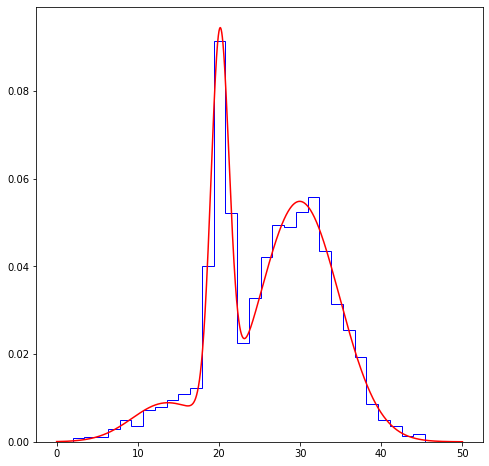

In [5]:


plt.figure(figsize=[8,8])
plt.hist(data, bins=30, fill=False, density=True, histtype='step', color='b', label='dataset')

gmm_best = GaussianMixture(n_components=best_aic_index, random_state=0, n_init=20).fit(data)

fx = lambda j : np.exp(gmm_best.score_samples(j.reshape(-1, 1))) # PDF

plt.plot(xgrid,fx(np.array(xgrid)), color='red', label='best model')

 - .predict_proba = Evaluate the components’ density for each sample.

Using this attribute I predict the pdf (y component), and than I split that in the 3 components of the model. I plot the result.

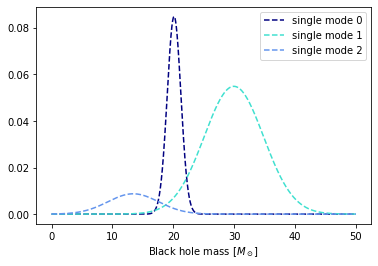

In [6]:
colors = ["navy", "turquoise", "cornflowerblue", "darkorange"]

predict_pdf = gmm_best.predict_proba(xgrid.reshape(-1,1))
single_pdf = predict_pdf * fx(xgrid)[:, np.newaxis]


for i in range(best_aic_index):
    plt.plot(xgrid, single_pdf[:,i],'--', c=colors[i], label='single mode %1.0f' % (i) )


plt.xlabel("Black hole mass $[M_\odot]$")
plt.legend(loc='best')
# plt.scatter(predict_pdf[0:-1],predict_pdf[1:], marker='x', color='black')

Just for fun , let me try Bootstrap and jacknife generating some gaussian points.

In [44]:
# Bootstrap

data = norm.rvs(loc=1, scale=0.1, size=10000, random_state=42)


np.random.seed(123)

# Draw some random sample with replacement and append mean to mean_lengths.
mean_lengths, sims = [], 1000
for i in range(sims):
    temp_sample = np.random.choice(data, replace=True, size=len(data))
    sample_mean = np.mean(temp_sample)
    mean_lengths.append(sample_mean)

# Calculate bootstrapped mean and 95% confidence interval.
boot_mean = np.mean(mean_lengths)
boot_95_ci = np.percentile(mean_lengths, [2.5, 97.5])
print("Bootstrapped Mean Length = {}, 95% CI = {}".format(boot_mean, boot_95_ci))

Bootstrapped Mean Length = 0.999762641188403, 95% CI = [0.99782452 1.0017218 ]


In [45]:
# Jacknife

np.random.seed(123)

# Leave one observation out from wrench_lengths to get the jackknife sample and store the mean length
mean_lengths, n = [], len(data)
index = np.arange(n)

for i in range(n):
    jk_sample = data[index != i]
    mean_lengths.append(np.mean(jk_sample))

# The jackknife estimate is the mean of the mean lengths from each sample
mean_lengths_jk = np.mean(np.array(mean_lengths))
print("Jackknife estimate of the mean = {}".format(mean_lengths_jk))

Jackknife estimate of the mean = 0.9997864016631575


(10000,)